<a href="https://colab.research.google.com/github/TJTomas/DSPS_TTomaszewski/blob/main/Labs/Copy_of_pinn_burgers_tofillin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.19.0'

In [2]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [3]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2025-11-18 21:41:56--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2025-11-18 21:41:56--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.002s  

2025-11-18 21:41:56 (101 MB/s) - ‘burgers_shock.mat’ sa

(100,) (256,) (256, 100)


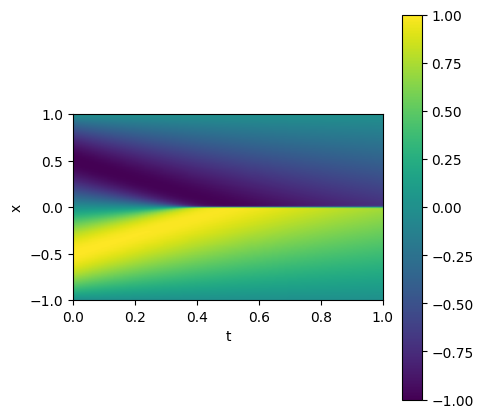

In [4]:
### what is the solution that we want? read in the data

# loading in a file saved as a binary (?) in mathematica
data = scipy.io.loadmat('burgers_shock.mat')

data.keys()

t = data['t'].flatten() #time
x = data['x'].flatten() #position
Z = np.real(data['usol']) #solution of Burger's Ee

print(t.shape, x.shape, Z.shape)

ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar(cb);


# PROBLEM SETUP: BURGER'S EQUATIONS
$$
\begin{align}
    \partial_t u (t,x) + {N}[u](t,x) &= 0, && (t,x) \in (0,T] \times {D},\\
    u(0,x) &= u_0(x) \quad && x \in {D},
\end{align}
$$


$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial {D},
\end{align}
$$


# SPECIFIC CASE: LIMIT REGIME AND SET VISCOSITY TO $\nu=0.01/\pi$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),&&\mathrm{eq.1}\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],&\mathrm{eq.2}\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [5]:
tf.random.set_seed(302)
pi = tf.constant(np.pi, dtype="float32")

In [6]:
def fun_u_0(x): #u(0,x) eq 2
  return -tf.sin(pi * x)

def fun_u_b(t, x): #u(t,x) - set up container
  return tf.zeros((x.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx): #derivatuve equation eq 1 - u_. is the derivative w respect to .
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

In [7]:
#number of points we are using for training and predicting
n_0 = 50 #points at t=0 -> initial conditions
n_b = 50 #points at b=[1;-1] -> boundary conditions
n_r = 10000

#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# get random data in x at t=0


In [8]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin #t=0
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        , -0.8135195 ],
       [ 0.        , -0.70707273],
       [ 0.        ,  0.01113892],
       [ 0.        , -0.36962843],
       [ 0.        , -0.82938004],
       [ 0.        , -0.255975  ],
       [ 0.        ,  0.67736554],
       [ 0.        , -0.32637262],
       [ 0.        ,  0.58469415],
       [ 0.        , -0.04957747],
       [ 0.        ,  0.06317472],
       [ 0.        , -0.22382426],
       [ 0.        , -0.5899384 ],
       [ 0.        , -0.11928439],
       [ 0.        , -0.17738795],
       [ 0.        , -0.85973954],
       [ 0.        , -0.20907187],
       [ 0.        ,  0.56759167],
       [ 0.        ,  0.542994  ],
       [ 0.        ,  0.5287423 ],
       [ 0.        ,  0.477237  ],
       [ 0.        , -0.8695276 ],
       [ 0.        ,  0.22201777],
       [ 0.        ,  0.29218197],
       [ 0.        ,  0.13996291],
       [ 0.        ,  0.8763921 ],
       [ 0.        , -0.40019774],
      

# evaluate initial condition at x_0

In [9]:
u_0 = fun_u_0(x_0) #eq 2
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[ 0.5529044 ],
       [ 0.795758  ],
       [-0.0349868 ],
       [ 0.9172904 ],
       [ 0.5107168 ],
       [ 0.7202546 ],
       [-0.8487336 ],
       [ 0.8548854 ],
       [-0.9648105 ],
       [ 0.15512328],
       [-0.19716886],
       [ 0.646635  ],
       [ 0.96034765],
       [ 0.36603338],
       [ 0.5288803 ],
       [ 0.4265194 ],
       [ 0.61060053],
       [-0.9775393 ],
       [-0.99089193],
       [-0.995926  ],
       [-0.9974441 ],
       [ 0.39850938],
       [-0.6422954 ],
       [-0.79433787],
       [-0.42567387],
       [-0.37863922],
       [ 0.9512483 ],
       [ 0.9167051 ],
       [ 0.9878706 ],
       [ 0.7186143 ],
       [-0.9833085 ],
       [-0.6321372 ],
       [-0.5283081 ],
       [-0.40588695],
       [-0.9998324 ],
       [-0.9243898 ],
       [ 0.80542755],
       [-0.49711674],
       [-0.39053267],
       [ 0.67776537],
       [-0.5861924 ],
       [ 0.8988876 ],
       [-0.21450849],
     

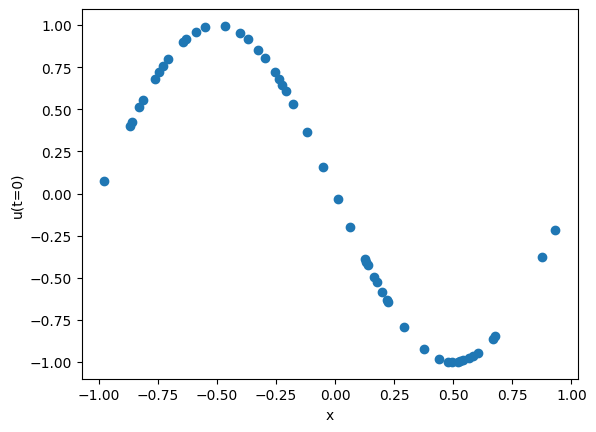

In [10]:
pl.scatter(x_0, u_0, marker='o', clim=(-1,1))
pl.xlabel("x")
pl.ylabel("u(t=0)");

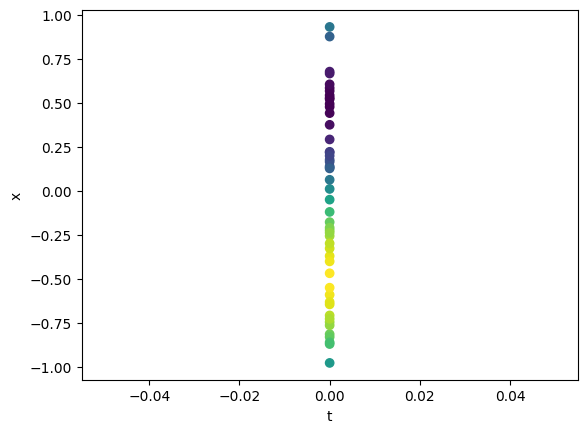

In [11]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

# get data at boundaries of x at random t's



In [12]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.3280692 ,  1.        ],
       [ 0.3035283 ,  1.        ],
       [ 0.48962092, -1.        ],
       [ 0.51018775,  1.        ],
       [ 0.35200047,  1.        ],
       [ 0.44924438,  1.        ],
       [ 0.6460984 , -1.        ],
       [ 0.90979755,  1.        ],
       [ 0.9901296 , -1.        ],
       [ 0.01110268,  1.        ],
       [ 0.2416197 ,  1.        ],
       [ 0.8868096 , -1.        ],
       [ 0.3184042 ,  1.        ],
       [ 0.5789492 , -1.        ],
       [ 0.17233837,  1.        ],
       [ 0.31018138, -1.        ],
       [ 0.66499794, -1.        ],
       [ 0.445727  ,  1.        ],
       [ 0.90419114, -1.        ],
       [ 0.34034097, -1.        ],
       [ 0.82913625, -1.        ],
       [ 0.8256103 , -1.        ],
       [ 0.7518388 ,  1.        ],
       [ 0.1880877 , -1.        ],
       [ 0.46998417, -1.        ],
       [ 0.9705193 , -1.        ],
       [ 0.77809596,  1.        ],
      

# evaluate data at boundaries of x at random t's


In [13]:
u_b = fun_u_b(t_b, x_b)
u_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

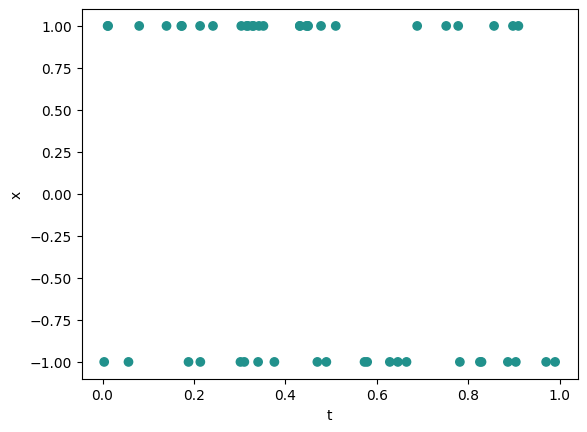

In [14]:
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

# get points inside the space at random where the function will be predicted

In [15]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.13965201, -0.62946033],
       [ 0.7194936 ,  0.02793384],
       [ 0.4555571 ,  0.07576776],
       ...,
       [ 0.8837193 , -0.6378081 ],
       [ 0.98897576, -0.7046833 ],
       [ 0.65506697, -0.14202952]], dtype=float32)>

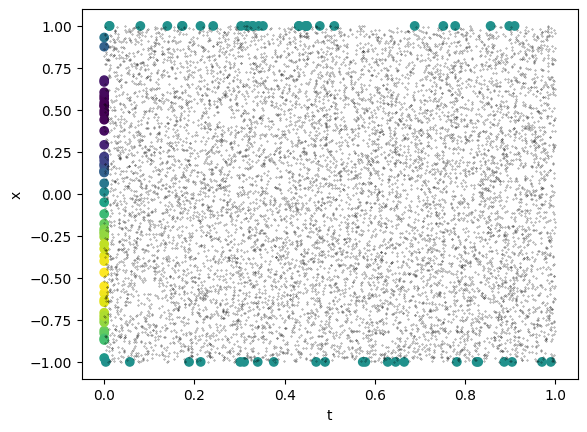

In [16]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c="k", marker='.', s=0.3, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

In [17]:
#put boundary conditionns together
X = tf.concat([X_0, X_b], axis=0)
y = tf.concat([u_0, u_b], axis=0)
X.shape, y.shape


(TensorShape([100, 2]), TensorShape([100, 1]))

# create the model with simple loss

In [31]:
nnmodel = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions - use tf.layer.Input()
nnmodel.add(tf.keras.layers.Input(shape=(2,)))

#8 hidden MLP layers of 20 neurons - you know these layers from last class
for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(20, activation="tanh"))

#output layer is 1D - use the correct activation function
nnmodel.add(tf.keras.layers.Dense(1))

In [32]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss(u_data, u_pred):
  return tf.reduce_mean(tf.square(u_data - u_pred))

In [33]:
nnmodel.compile(loss=custom_loss, optimizer=optim)

## train the model

In [34]:
history = nnmodel.fit(X, y, epochs=1000)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 332ms/step - loss: 0.3190
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2099 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2332 
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2326 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2111 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2012 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1981 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1937 
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1912 
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1905 
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1859 
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1780 
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1705 
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1636 
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1575 
Epo

Text(0, 0.5, 'loss')

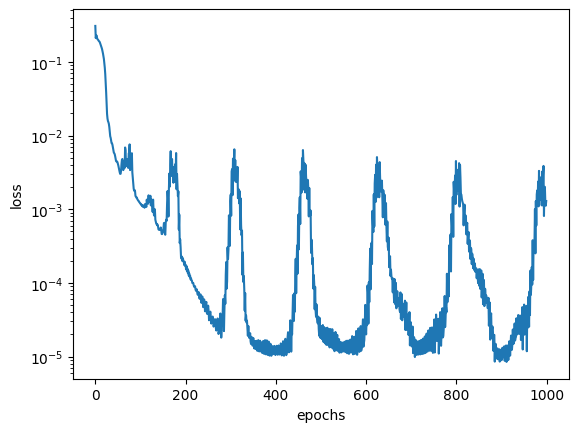

In [35]:
pl.semilogy(history.history["loss"])
pl.xlabel("epochs")
pl.ylabel("loss")

## see the result

In [36]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[ 0.44912466],
       [-0.14471398],
       [-0.19818608],
       ...,
       [-0.01183816],
       [-0.01635027],
       [-0.10456041]], dtype=float32)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


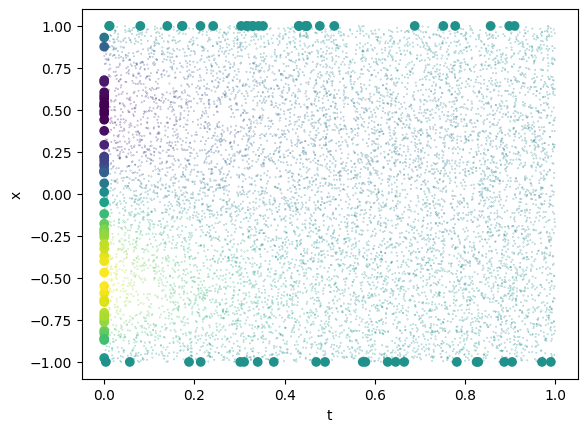

In [37]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=nnmodel.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

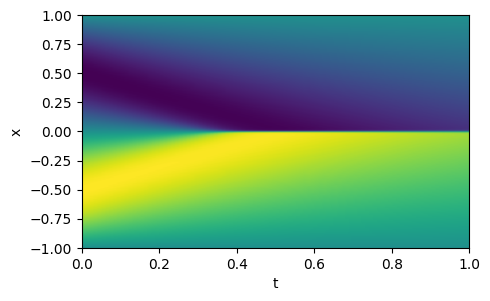

In [38]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);


show the accuracy for every point that you solved for

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━

np.float64(-19.88272784787247)

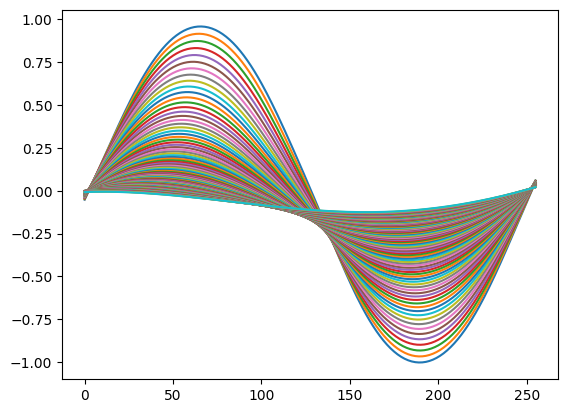

In [39]:
def L1accuracy(t, x, model):
  tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
  tmp_[:,1] += x
  acc = 0
  for tt in range(t.shape[0]):
    tmp_[:,0] = t[tt]
    pl.plot(model.predict(tmp_))
    acc += (model.predict(tmp_) - Z[:,tt]).sum()


  return acc / np.prod(t.shape[0] * x.shape[0])
L1accuracy(t, x, nnmodel)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


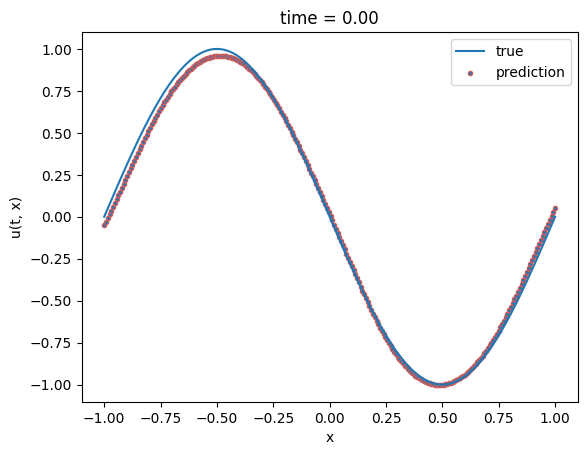

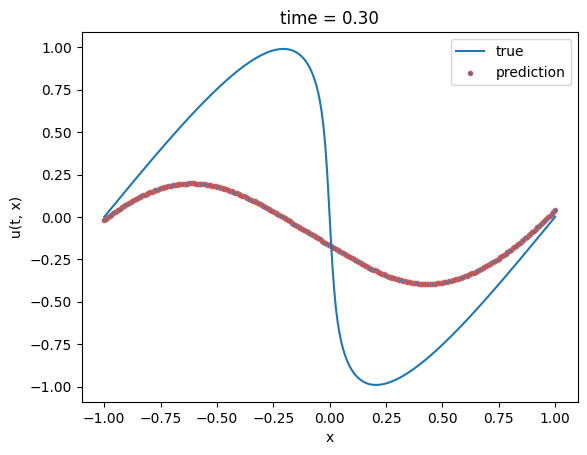

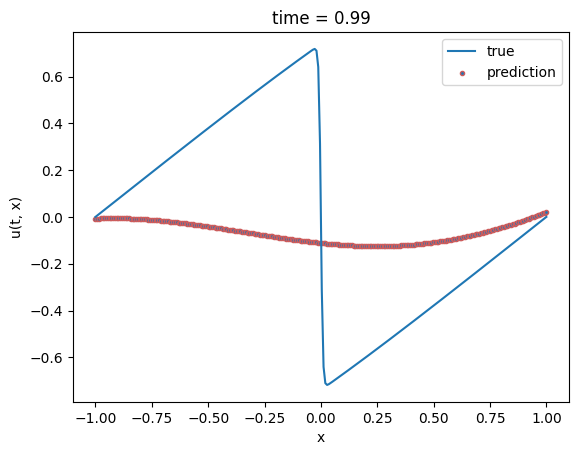

In [40]:
tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
tmp_[:,1] += x
inds = [0, 30, -1]
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, nnmodel.predict(tmp_), marker='.', edgecolors="IndianRed",
             label="prediction")
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();


# create the model with complete loss

In [41]:
def get_pde(model, X_r):

  with tf.GradientTape(persistent=True) as tape:
      t, x = X_r[:,0:1], X_r[:,1:2]
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1))
      u_x = tape.gradient(u,x)
      #print(u_x)
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape # to save some memory

  return u, u_t, u_x, u_xx # this function gets the pde solution where its available


In [42]:
def custom_loss(model, X_r, X, y):
  # Data loss from initial and boundary conditions
  u_pred = model(X)
  data_loss = tf.reduce_mean(tf.square(u_pred - y))

  # PDE residual loss
  u, u_t, u_x, u_xx = get_pde(model, X_r)
  pde_residual = fun_res(u, u_t, u_x, u_xx)
  pde_loss = tf.reduce_mean(tf.square(pde_residual))

  # Combine losses
  return data_loss + pde_loss

  # This may be wrong, change this from master document later

In [43]:
def get_grad(model, X_r, X, y):
    # model derivatives for backprop
    with tf.GradientTape(persistent=True) as tape:
        # tape.watch(model.trainable_variables) # Removed to avoid __repr__ call during tf.function tracing
        loss = custom_loss(model, X_r, X, y)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

## train the model

In [44]:
import copy

In [45]:
pinn = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
pinn.add(tf.keras.layers.Input(shape=(2,)))

#hidden layers
for i in range(8):
  pinn.add(tf.keras.layers.Dense(20, activation="tanh"))

#output layer is 1D
pinn.add(tf.keras.layers.Dense(1))

In [46]:
tf.config.run_functions_eagerly(True)
@tf.function
def train_step(model, X_r, X, y):

  loss, grad = get_grad(model, X_r, X, y)
  optim.apply_gradients(zip(grad, model.trainable_variables))
  return loss

optim = tf.keras.optimizers.Adam(learning_rate=0.05)
pinn.compile(loss=custom_loss, optimizer=optim) #change the loss and optimization

history = []
Nepochs = 5000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 6.40568733e-01
It 00050: loss = 2.11885467e-01
It 00100: loss = 1.60286859e-01
It 00150: loss = 1.22221410e-01
It 00200: loss = 1.64493799e-01
It 00250: loss = 7.08850324e-02
It 00300: loss = 1.03306614e-01
It 00350: loss = 6.52746558e-02
It 00400: loss = 5.42291105e-02
It 00450: loss = 2.69256562e-01
It 00500: loss = 1.54541939e-01
It 00550: loss = 1.50028527e-01
It 00600: loss = 2.19870210e-01
It 00650: loss = 2.70520687e-01
It 00700: loss = 2.70423502e-01
It 00750: loss = 2.70392567e-01
It 00800: loss = 2.70346791e-01
It 00850: loss = 2.61092454e-01
It 00900: loss = 2.67665446e-01
It 00950: loss = 2.20144689e-01
It 01000: loss = 1.55469760e-01
It 01050: loss = 1.53068796e-01
It 01100: loss = 1.54506192e-01
It 01150: loss = 1.97746679e-01
It 01200: loss = 1.55584246e-01
It 01250: loss = 1.53626546e-01
It 01300: loss = 1.57345310e-01
It 01350: loss = 1.55259728e-01
It 01400: loss = 1.48648053e-01
It 01450: loss = 1.57948107e-01
It 01500: loss = 1.53178409e-01
It 01550

 11/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


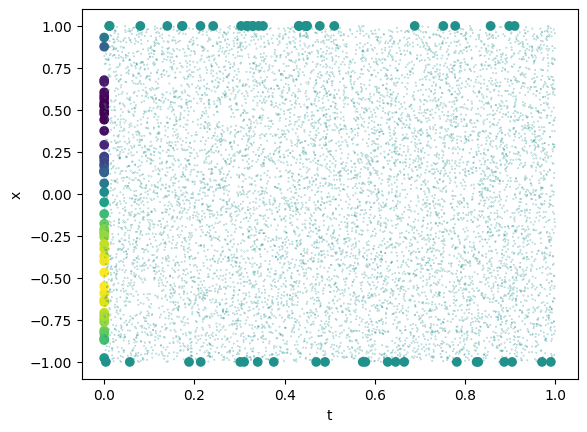

In [47]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


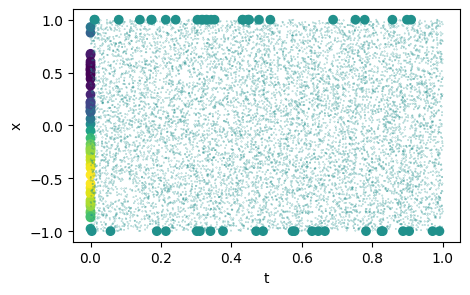

In [48]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
ax.set_aspect(0.3);

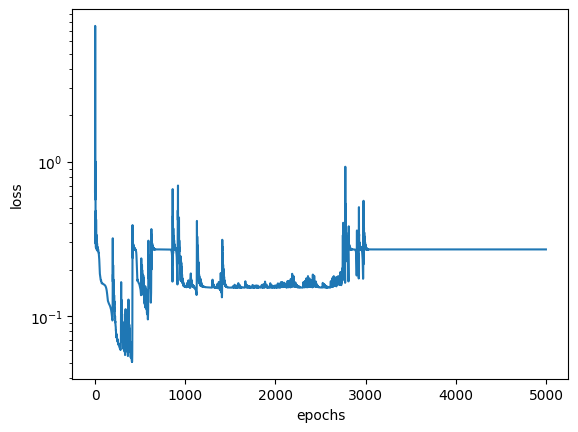

In [49]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss");

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━

np.float64(-0.8113670900465709)

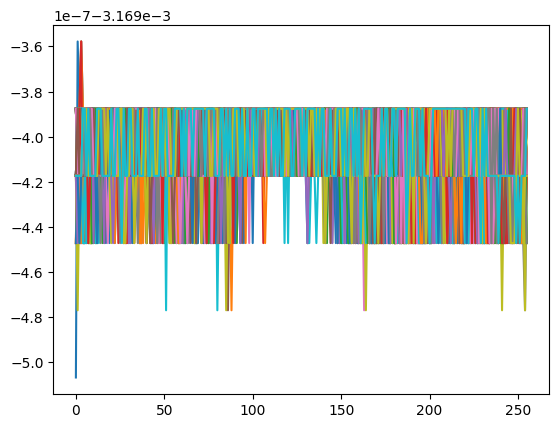

In [50]:
L1accuracy(t, x, pinn)

# adjust the learning rate and train some more
the loss was awfully noisy

In [ ]:
from tensorflow.keras.backend import set_value
set_value(pinn.optimizer.lr, 0.0001)

In [ ]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))


In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot()
ax.imshow(Z[::-1],extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);

In [ ]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

## final result

In [ ]:
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]])
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, pinn.predict(tmp_), marker='.', edgecolors="IndianRed")
  pl.xlabel("x")
  pl.ylabel("u(t, x)");

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.imshow(Z[::-1], extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
#pl.colorbar();

In [ ]:
L1accuracy(t, x, pinn)